In [94]:
from pathlib import Path
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
from matplotlib.dates import relativedelta
import xgboost as xgb
from typing import Tuple
from plotnine import labs

In [53]:
pd.set_option('display.max_columns', None)

In [54]:
data_path = Path("../data")

In [55]:
df = pd.read_parquet(data_path / "full_data.parquet")

In [56]:
column_order = [
    'advertiser_zrive_id',
    'period_int',
    'monthly_published_ads',
    'monthly_published_ads_3_months_mean',
    'monthly_published_ads_3_months_mean_delta',
    'monthly_unique_published_ads',
    'monthly_contracted_ads',
    'monthly_contracted_ads_3_months_mean',
    'monthly_contracted_ads_3_months_mean_delta',
    'monthly_leads',
    'monthly_leads_3_months_mean',
    'monthly_leads_3_months_mean_delta',
    'monthly_visits',
    'monthly_visits_3_months_mean',
    'monthly_visits_3_months_mean_delta',
    'monthly_oro_ads',
    'monthly_plata_ads',
    'monthly_destacados_ads',
    'monthly_pepitas_ads',
    'monthly_shows',
    'monthly_total_phone_views',
    'monthly_total_calls',
    'monthly_total_emails',
    'monthly_total_invoice',
    'monthly_total_invoice_3_months_mean',
    'monthly_total_invoice_3_months_mean_delta',
    'monthly_unique_calls',
    'monthly_unique_emails',
    'monthly_unique_leads',
    'monthly_avg_ad_price',
    'monthly_avg_ad_price_3_months_mean',
    'monthly_avg_ad_price_3_months_mean_delta',
    'monthly_distinct_ads',
    'month_period',
    'tenure',
    'months_since_last_contract',
    'has_renewed',
    'monthly_total_premium_ads',
    'ratio_published_contracted',
    'ratio_published_contracted_3_months_mean',
    'ratio_published_contracted_3_months_mean_delta',
    'ratio_unique_published',
    'ratio_unique_published_3_months_mean',
    'ratio_unique_published_3_months_mean_delta',
    'ratio_premium_ads',
    'ratio_premium_ads_3_months_mean',
    'ratio_premium_ads_3_months_mean_delta',
    'leads_per_published_ad',
    'leads_per_published_ad_3_months_mean',
    'leads_per_published_ad_3_months_mean_delta',
    'leads_per_premium_ad',
    'leads_per_premium_ad_3_months_mean',
    'leads_per_premium_ad_3_months_mean_delta',
    'visits_per_published_ad',
    'visits_per_published_ad_3_months_mean',
    'visits_per_published_ad_3_months_mean_delta',
    'leads_per_visit',
    'leads_per_visit_3_months_mean',
    'leads_per_visit_3_months_mean_delta',
    'leads_per_shows',
    'leads_per_shows_3_months_mean',
    'leads_per_shows_3_months_mean_delta',
    'invoice_per_published_ad',
    'invoice_per_published_ad_3_months_mean',
    'invoice_per_published_ad_3_months_mean_delta',
    'invoice_per_lead',
    'invoice_per_lead_3_months_mean',
    'invoice_per_lead_3_months_mean_delta',
    'churn'
]

df = df[column_order]
df['churn'] = df['churn'].astype(int)

In [57]:
df = df.drop(['monthly_distinct_ads', 'monthly_avg_ad_price', 'monthly_avg_ad_price_3_months_mean', 'monthly_avg_ad_price_3_months_mean_delta' ], axis=1)

In [58]:
ids_with_nan = df[
    df['tenure'].isna() | df['months_since_last_contract'].isna()
]['advertiser_zrive_id'].unique()

df = df[~df['advertiser_zrive_id'].isin(ids_with_nan)]

In [59]:
info_cols = ['advertiser_zrive_id', 'period_int', 'month_period']
label_col = 'churn'
features_cols = [col for col in df.columns if col not in info_cols + [label_col]]


binary_cols = ['has_renewed']
numerical_cols = [col for col in features_cols if col not in  binary_cols]

In [60]:
def feature_label_split(df: pd.DataFrame, label_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    return df.drop(label_col, axis=1), df[label_col]

In [61]:
train_cols = numerical_cols + binary_cols

In [62]:
import pandas as pd
import re
import numpy as np
from xgboost import XGBClassifier
from plotnine import ggplot, geom_histogram, aes, geom_col, coord_flip, geom_bar,scale_x_discrete, geom_point, theme,element_text, geom_boxplot, coord_cartesian, scale_color_manual

In [63]:
def split_train_test_by_period(data_set, execution_date):
    train_end_date = execution_date + relativedelta(months=6)
    val_date = execution_date + relativedelta(months=7)

    train_start_str = execution_date.strftime('%Y%m')
    train_end_str = train_end_date.strftime('%Y%m')
    val_str = val_date.strftime('%Y%m')

    train_set = data_set[
        (data_set['month_period'] >= train_start_str) &
        (data_set['month_period'] <= train_end_str)
    ]
    test_set = data_set[data_set['month_period'] == val_str]

    return train_set, test_set

In [64]:
import warnings
warnings.filterwarnings('ignore')

def train_model(X_train, X_test, n_estimators=300):
    y_train = X_train["churn"]
    y_test = X_test["churn"]

    X_train["month_period"] = X_train["month_period"].astype("category").cat.codes
    X_test["month_period"] = X_test["month_period"].astype("category").cat.codes

    dtrain = xgb.DMatrix(X_train.drop(columns="churn"), label=y_train)
    dtest = xgb.DMatrix(X_test.drop(columns="churn"), label=y_test)

    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "seed": 1,
        "nthread": 10,
    }

    evals_result = {}
    evals = [(dtest, "eval"), (dtrain, "train")]

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=n_estimators,
        evals=evals,
        evals_result=evals_result,
        verbose_eval=False
    )

    return model, evals_result

In [65]:
def run_model_for_execution_date(execution_date, all_results, all_models, n_estimators):
        global train_set
        global test_set
        # split the dataset between train and test
        train_set, test_set = split_train_test_by_period(df, execution_date)
        train_size, _ = train_set.shape
        test_size, _ = test_set.shape
        model = None

        # if both train and test are not empty
        if train_size > 0 and test_size>0:
            model, evals_result = train_model(train_set, test_set, n_estimators = n_estimators)

            all_results[(execution_date)] = evals_result
            all_models[(execution_date)] = model

        return all_results, all_models

In [66]:
all_results = {}
all_predicted_tickers_list = []
all_models = {}

params = {
    "random_state": 1,
    "verbosity": -1,
    "n_jobs": 10,
    "objective": 'binary',
    "metric": 'binary_logloss',
    "n_estimators": 40
}

In [67]:
def train_model_across_periods(n_estimators):
    global all_results
    global all_models

    start_date = datetime.datetime(2023, 3, 1)
    end_date = datetime.datetime(2024, 11, 1)
    current_date = start_date

    while current_date + relativedelta(months=7) <= end_date:
        print(current_date)
        all_results, all_models= run_model_for_execution_date(
            current_date, all_results, all_models, n_estimators
        )

        current_date += relativedelta(months=1)

train_model_across_periods(n_estimators=params["n_estimators"])

2023-03-01 00:00:00
2023-04-01 00:00:00
2023-05-01 00:00:00
2023-06-01 00:00:00
2023-07-01 00:00:00
2023-08-01 00:00:00
2023-09-01 00:00:00
2023-10-01 00:00:00
2023-11-01 00:00:00
2023-12-01 00:00:00
2024-01-01 00:00:00
2024-02-01 00:00:00
2024-03-01 00:00:00
2024-04-01 00:00:00


In [68]:
def return_learning_curve(set_name):
    learning_curves = pd.DataFrame()
    for date in all_results:
        learning_curve = pd.DataFrame(all_results[date][set_name])
        learning_curve["n_trees"] = list(range(len(learning_curve)))
        learning_curve["execution_date"] = date
        learning_curves = pd.concat([learning_curves, learning_curve])

    for column in learning_curves.columns:
        if column not in ["n_trees", "execution_date"]:
            first_metric = learning_curves[[column, "execution_date"]].drop_duplicates(['execution_date'])
            first_metric = first_metric.rename(columns={column: "first_" + column})
            learning_curves = pd.merge(learning_curves, first_metric, on=["execution_date"])
            learning_curves["norm_" + column] = (learning_curves[column] - learning_curves["first_" + column]) / learning_curves["first_" + column]
            learning_curves = learning_curves.drop(columns="first_" + column)
    learning_curves["execution_date"] = learning_curves["execution_date"].astype(str)

    return learning_curves

In [69]:
test_lc = return_learning_curve("eval")
train_lc = return_learning_curve("train")

In [70]:
train_lc['n_trees_cat'] = pd.Categorical(train_lc['n_trees'], categories=sorted(train_lc['n_trees'].unique()))
test_lc['n_trees_cat'] = pd.Categorical(test_lc['n_trees'], categories=sorted(test_lc['n_trees'].unique()))

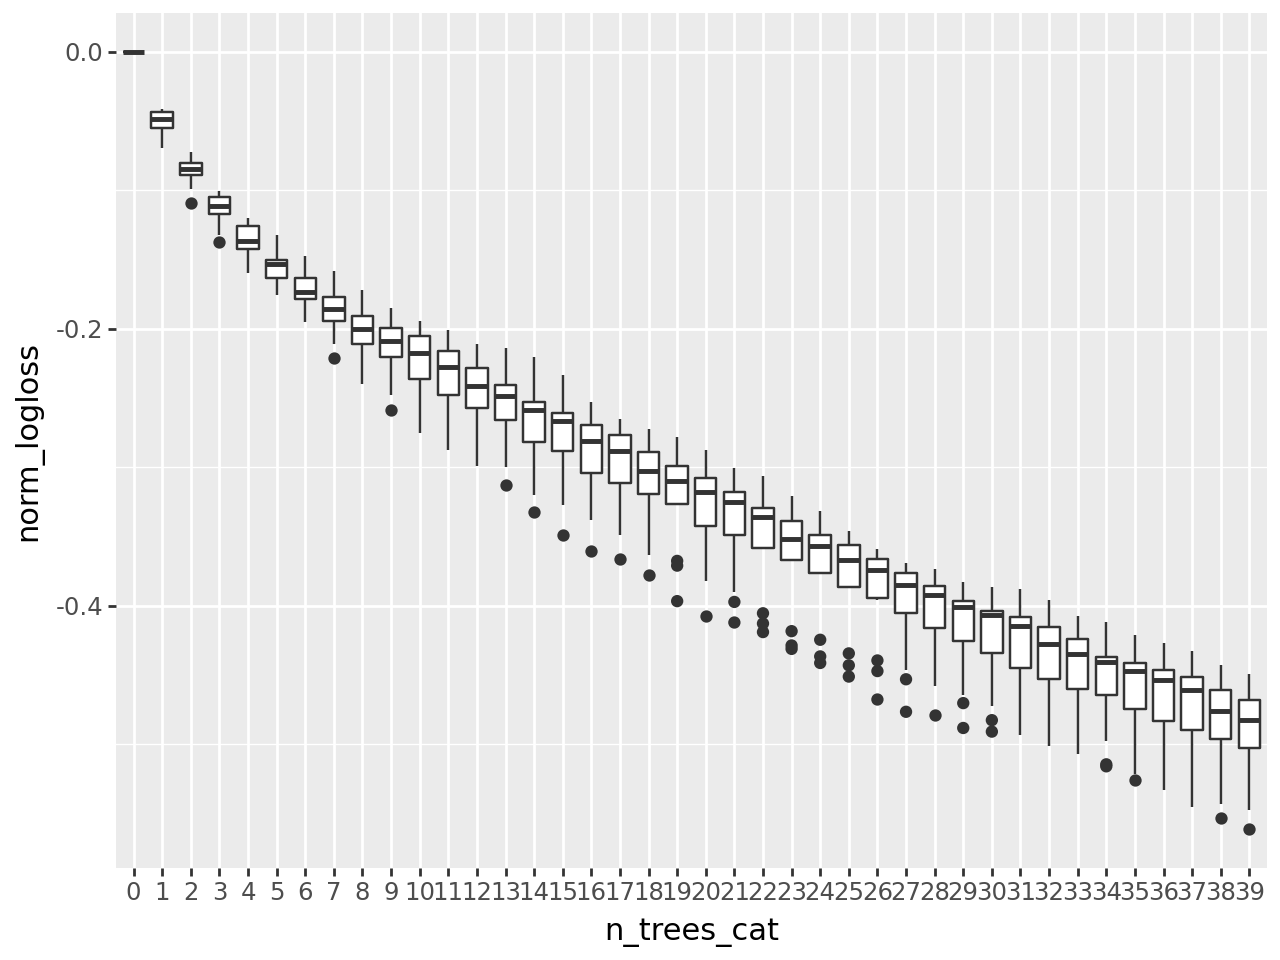

In [71]:
ggplot(train_lc, aes(x="n_trees_cat", y="norm_logloss")) + geom_boxplot()

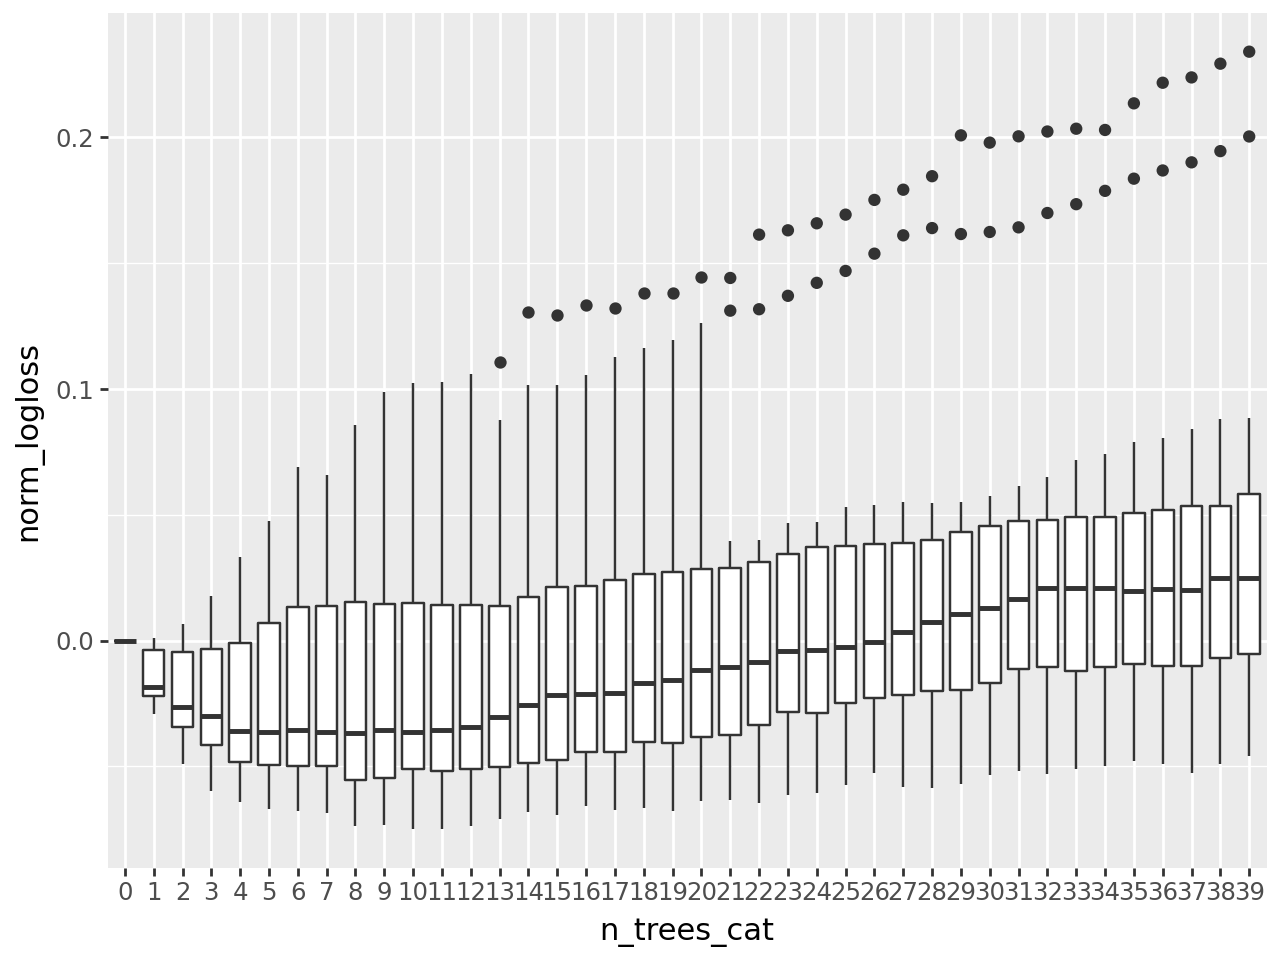

In [72]:
ggplot(test_lc, aes(x="n_trees_cat", y="norm_logloss")) + geom_boxplot()

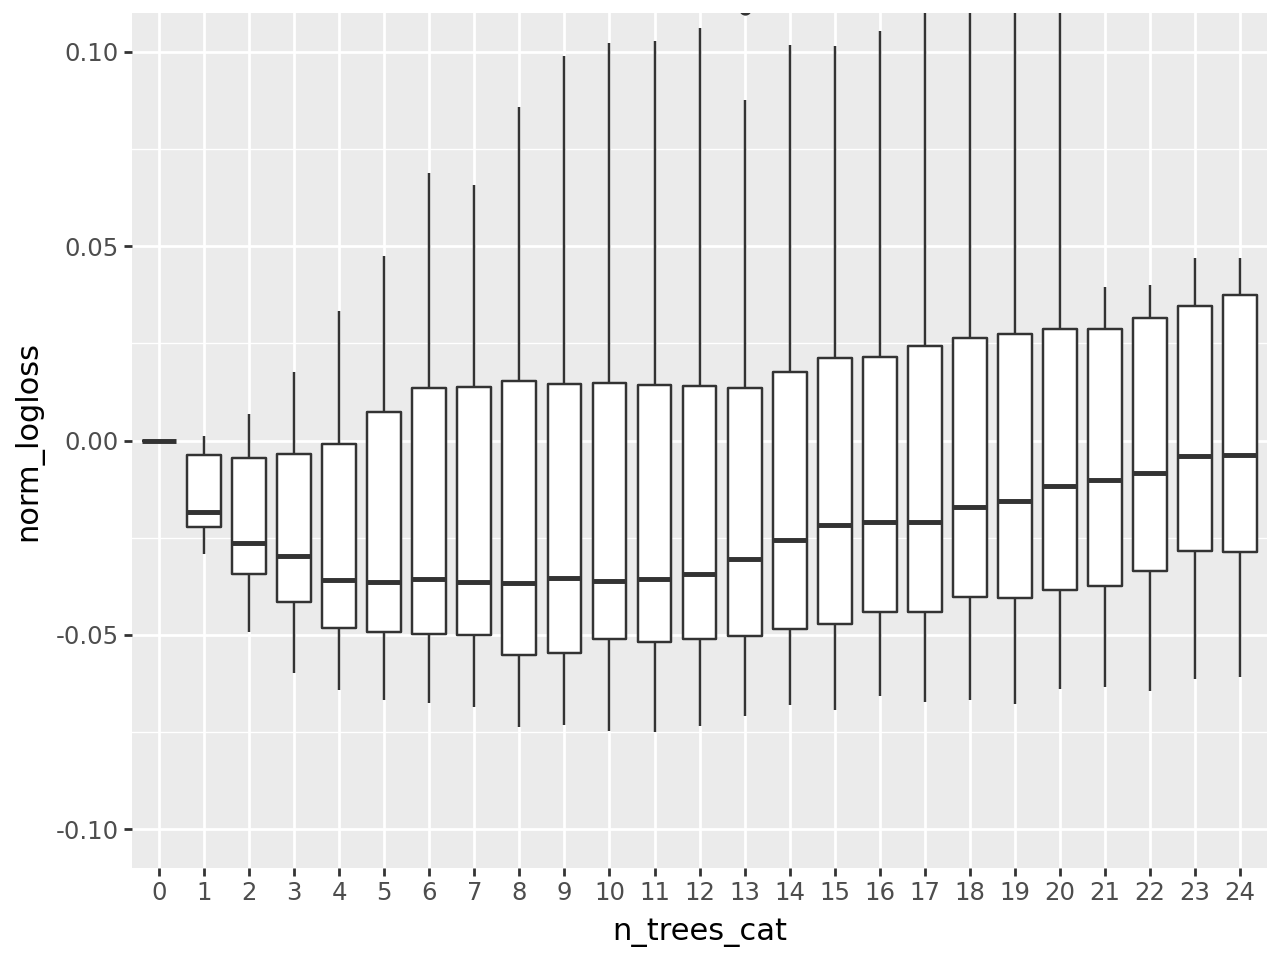

In [73]:
ggplot(test_lc[test_lc["n_trees"] < 25], aes(x="n_trees_cat", y="norm_logloss")) + geom_boxplot(outlier_alpha=None) + coord_cartesian(ylim=[-0.1, 0.1])

In [74]:
def train_model(X_train, X_test, n_estimators=300):
    y_train = X_train["churn"]
    y_test = X_test["churn"]

    X_train["month_period"] = X_train["month_period"].astype("category").cat.codes
    X_test["month_period"] = X_test["month_period"].astype("category").cat.codes

    dtrain = xgb.DMatrix(X_train.drop(columns="churn"), label=y_train)
    dtest = xgb.DMatrix(X_test.drop(columns="churn"), label=y_test)

    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "learning_rate": 0.01,
        "max_depth": 3,
        "min_child_weight": 10,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "reg_alpha": 1.0,
        "reg_lambda": 1.0,
        "nthread": 10,
        "random_state": 1
    }

    evals_result = {}

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=n_estimators,
        evals=[(dtest, "eval"), (dtrain, "train")],
        early_stopping_rounds=20,
        verbose_eval=False,
        evals_result=evals_result
    )

    return model, evals_result

In [75]:
train_model_across_periods(n_estimators=200)

2023-03-01 00:00:00
2023-04-01 00:00:00
2023-05-01 00:00:00
2023-06-01 00:00:00
2023-07-01 00:00:00
2023-08-01 00:00:00
2023-09-01 00:00:00
2023-10-01 00:00:00
2023-11-01 00:00:00
2023-12-01 00:00:00
2024-01-01 00:00:00
2024-02-01 00:00:00
2024-03-01 00:00:00
2024-04-01 00:00:00


In [76]:
test_lc = return_learning_curve("eval")
train_lc = return_learning_curve("train")

In [77]:
train_lc['n_trees_cat'] = pd.Categorical(train_lc['n_trees'], categories=sorted(train_lc['n_trees'].unique()))
test_lc['n_trees_cat'] = pd.Categorical(test_lc['n_trees'], categories=sorted(test_lc['n_trees'].unique()))

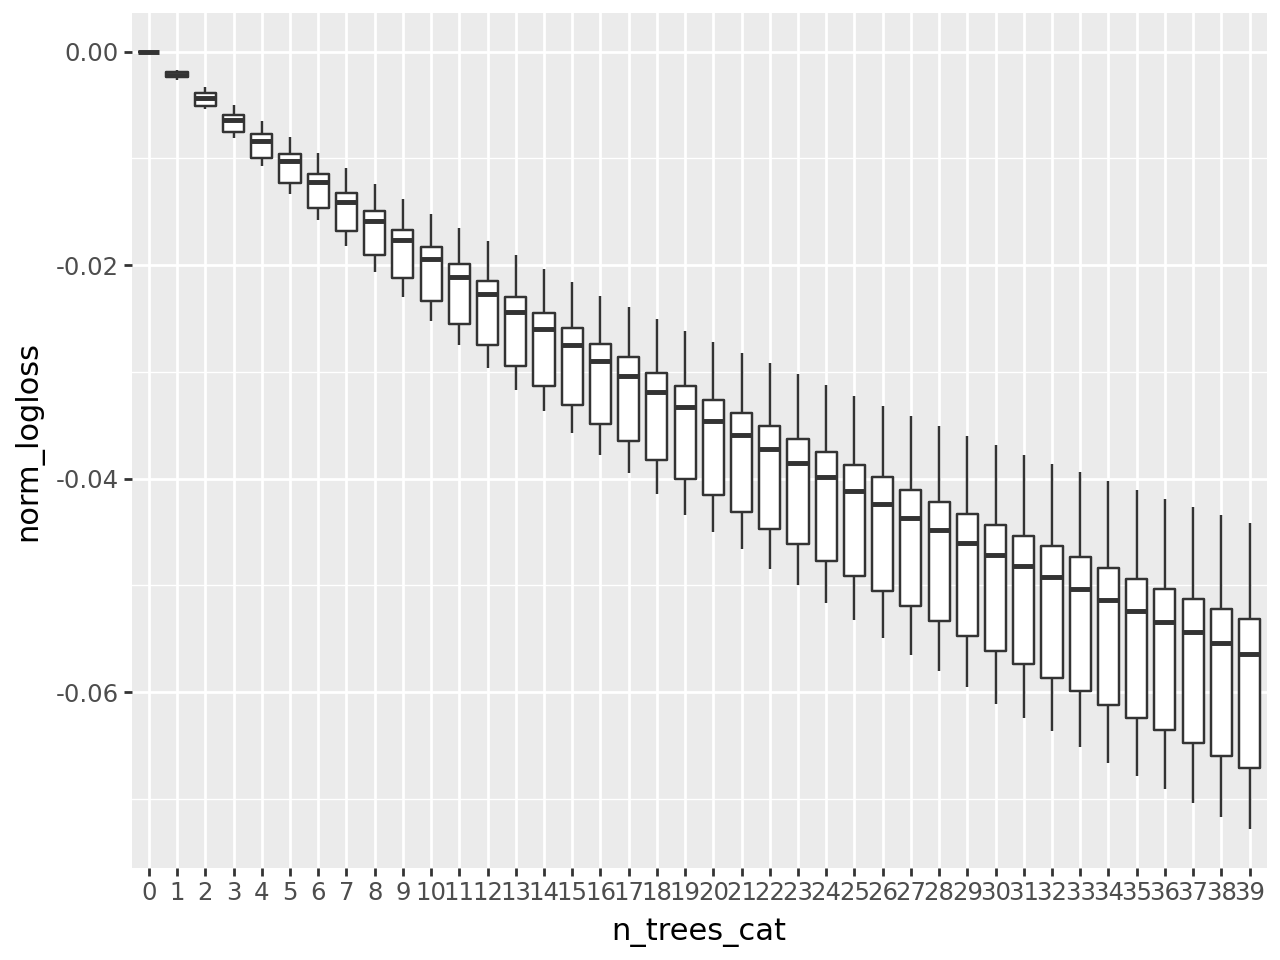

In [78]:
ggplot(train_lc[train_lc["n_trees"] < 40], aes(x="n_trees_cat", y="norm_logloss")) + geom_boxplot()

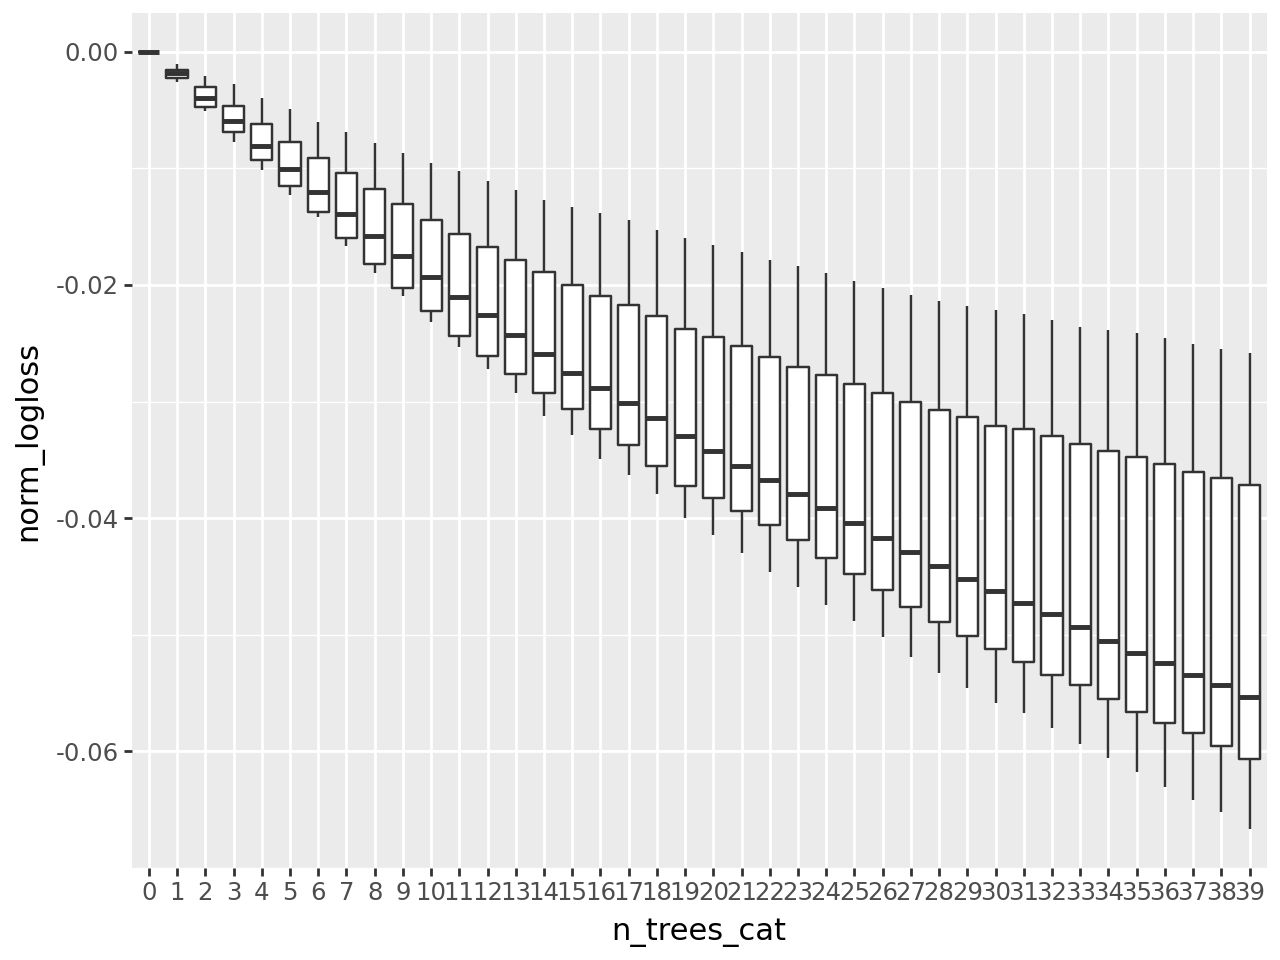

In [79]:
ggplot(test_lc[test_lc["n_trees"] < 40], aes(x="n_trees_cat", y="norm_logloss")) + geom_boxplot()

In [80]:
train_lc['n_trees_cat'] = pd.Categorical(train_lc['n_trees'], categories=sorted(test_lc['n_trees'].unique()))
test_lc['n_trees_cat'] = pd.Categorical(test_lc['n_trees'], categories=sorted(test_lc['n_trees'].unique()))

filtered_train_lc = train_lc[train_lc["n_trees"] % 10 == 0].copy()
filtered_test_lc = test_lc[test_lc["n_trees"] % 10 == 0].copy()

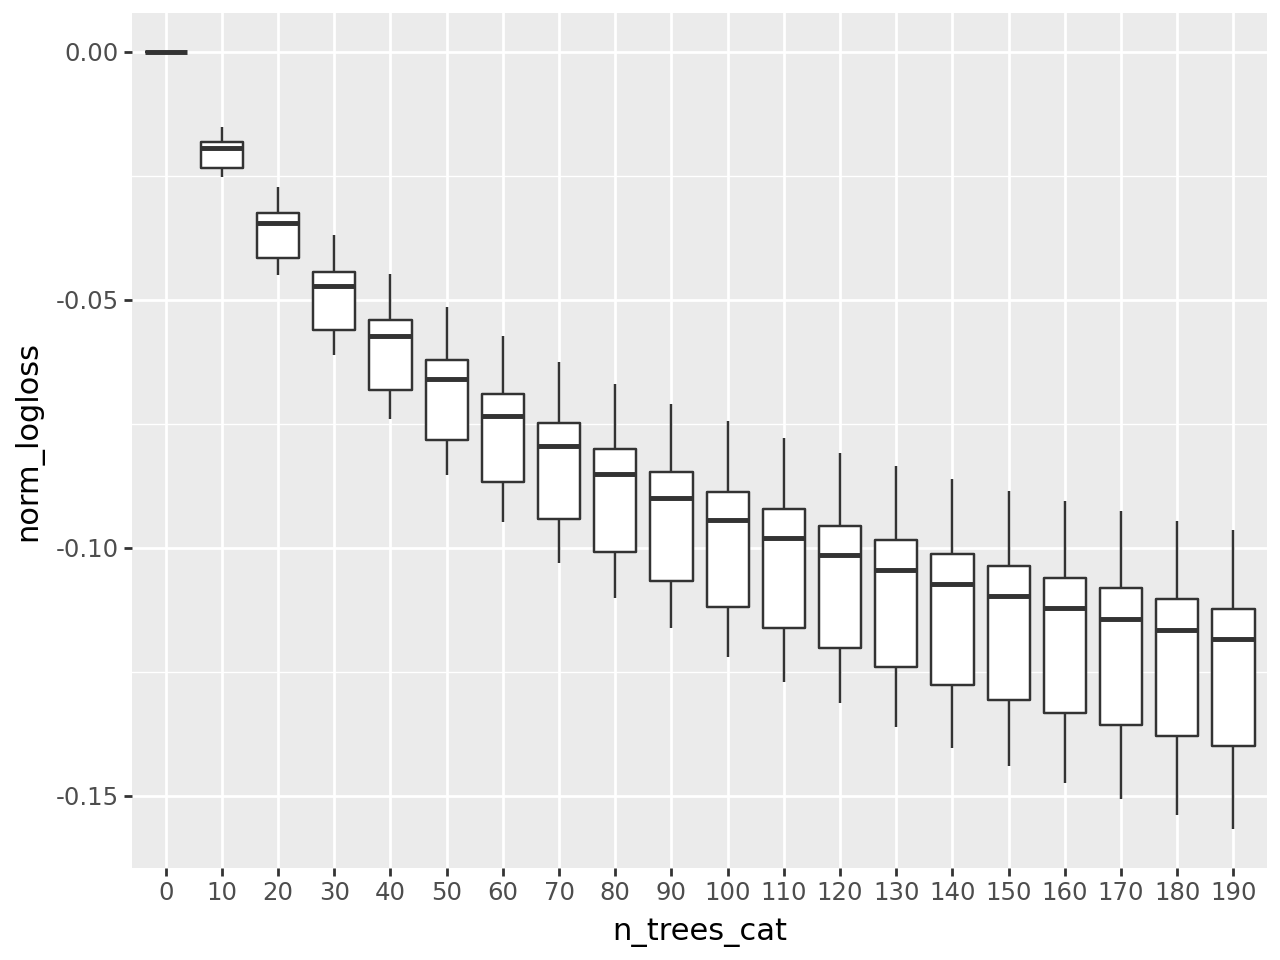

In [81]:
ggplot(filtered_train_lc, aes(x="n_trees_cat", y="norm_logloss")) + geom_boxplot()

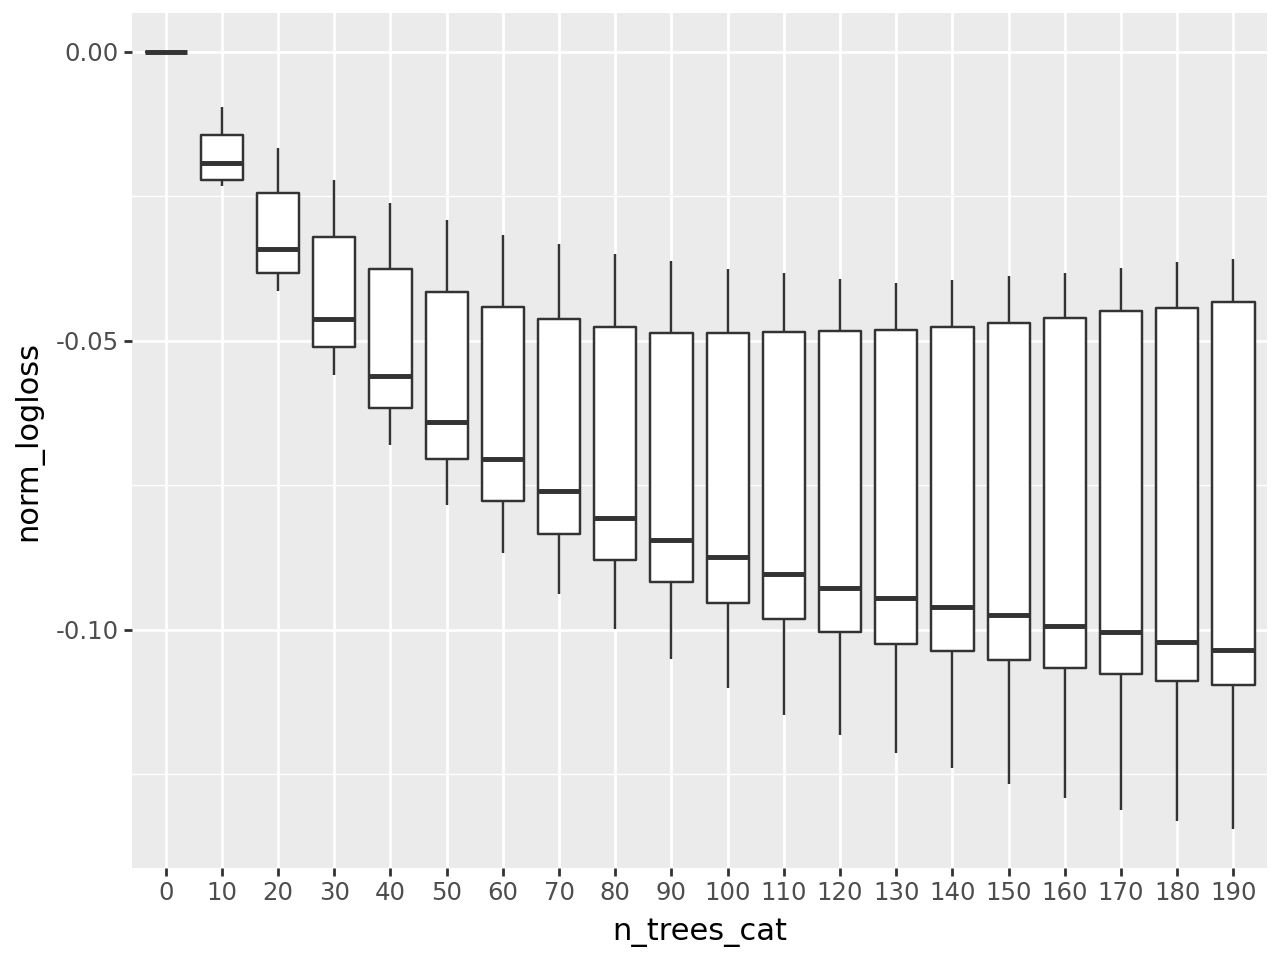

In [82]:
ggplot(filtered_test_lc, aes(x="n_trees_cat", y="norm_logloss")) + geom_boxplot()

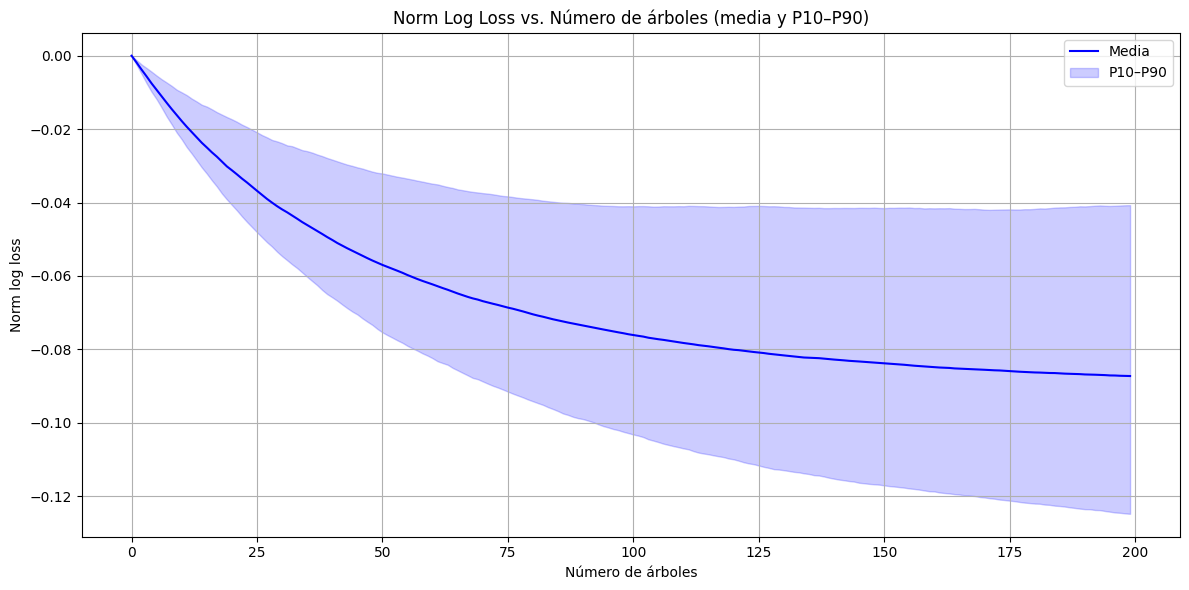

In [83]:
summary = test_lc.groupby("n_trees")["norm_logloss"].agg(
    mean="mean",
    p10=lambda x: x.quantile(0.10),
    p90=lambda x: x.quantile(0.90)
).reset_index()

# Gráfico
plt.figure(figsize=(12, 6))
plt.plot(summary["n_trees"], summary["mean"], label="Media", color="blue")
plt.fill_between(summary["n_trees"], summary["p10"], summary["p90"], color="blue", alpha=0.2, label="P10–P90")
plt.xlabel("Número de árboles")
plt.ylabel("Norm log loss")
plt.title("Norm Log Loss vs. Número de árboles (media y P10–P90)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [84]:
train_lc["set"] = "train"
test_lc["set"] = "test"

data_lc = pd.concat([train_lc, test_lc])

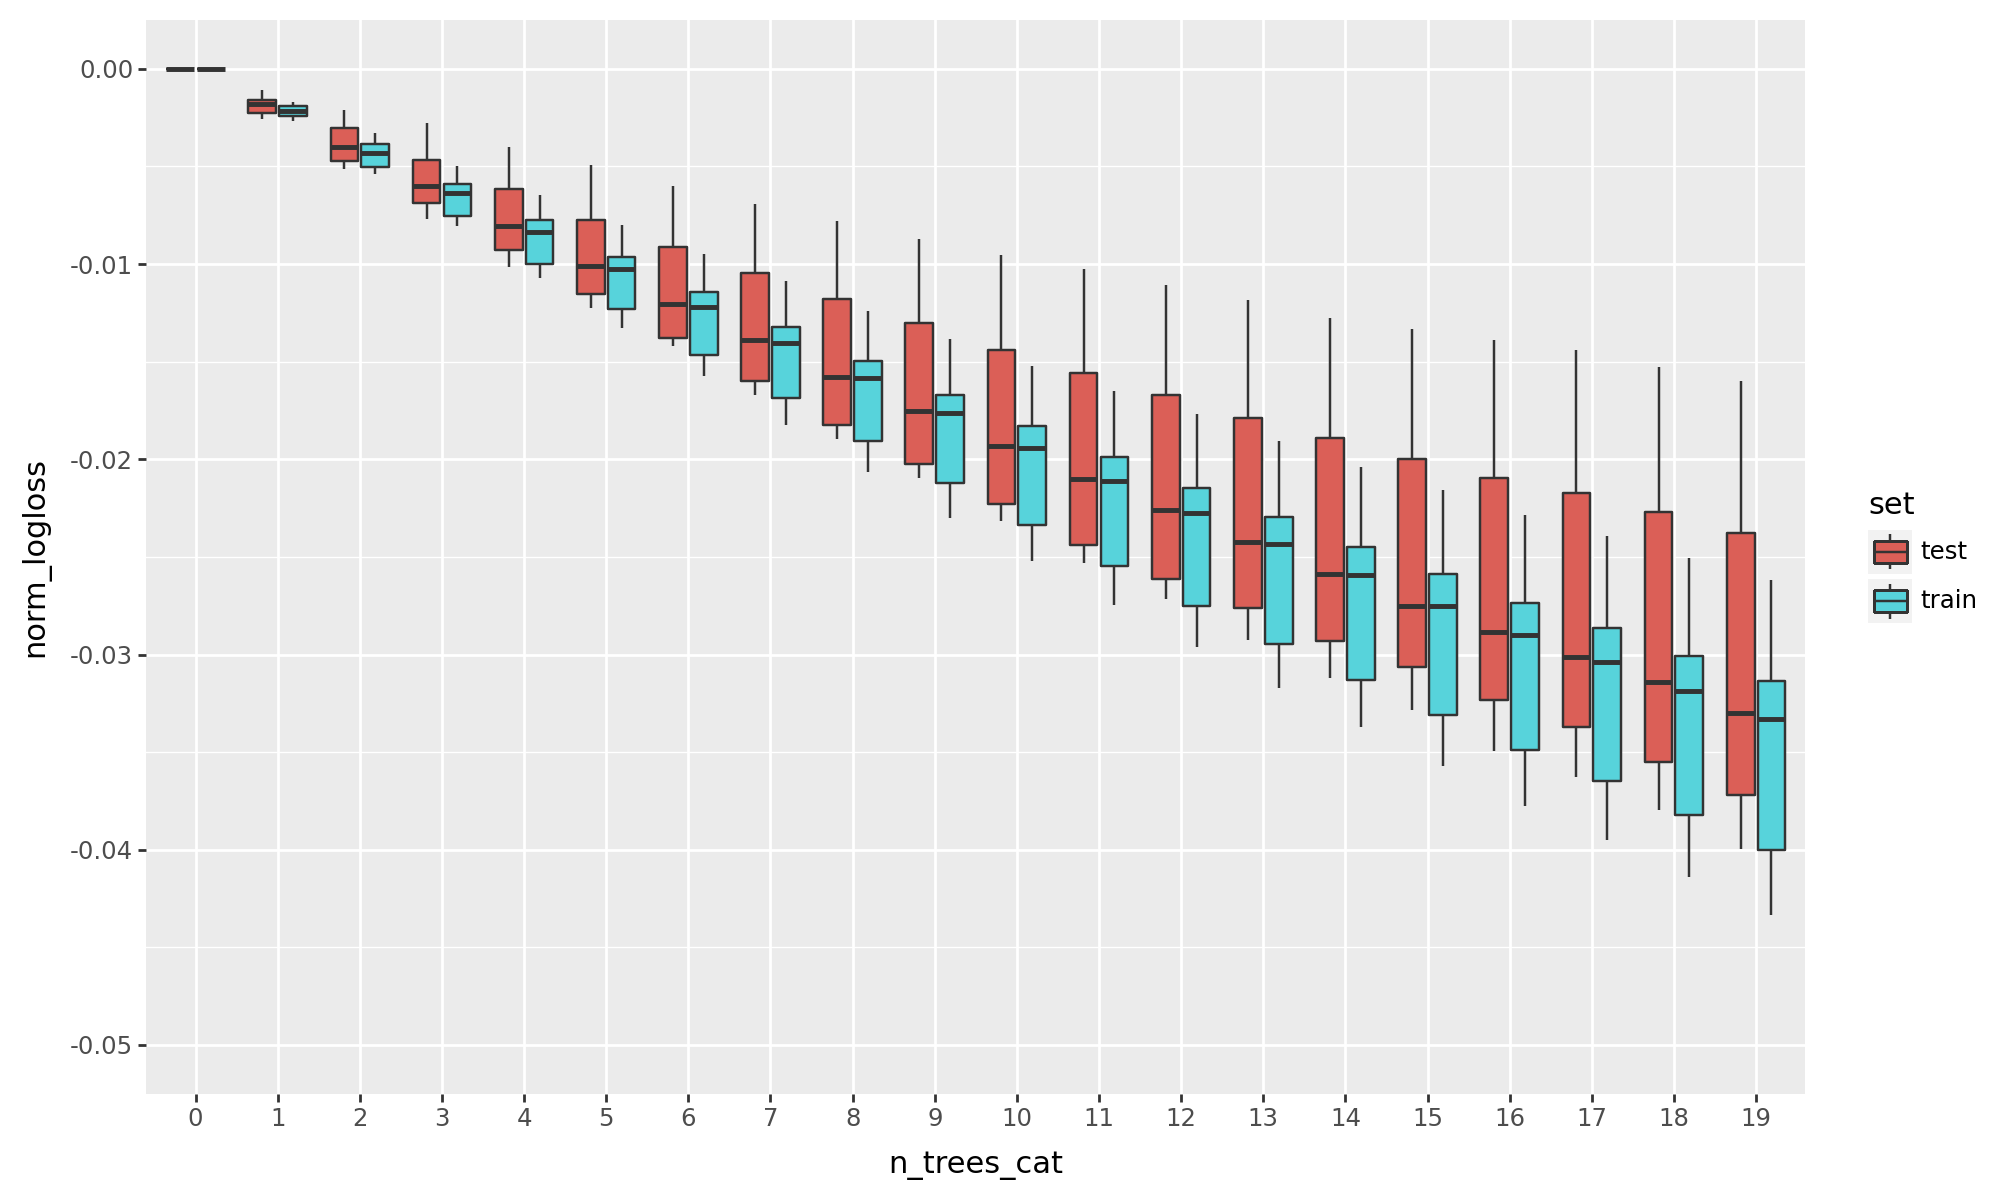

In [85]:
fig = plt.figure(figsize=(10, 6))

ggplot(
    data_lc[data_lc["n_trees"] < 20],
    aes(x="n_trees_cat", y="norm_logloss", fill="set")
) + geom_boxplot(outlier_alpha=None) + coord_cartesian(ylim=(-0.05, 0)) + theme(
    figure_size=(10, 6)
)

In [87]:
def train_model(X_train, X_test, n_estimators=300):
    y_train = X_train["churn"]
    y_test = X_test["churn"]

    X_train["month_period"] = X_train["month_period"].astype("category").cat.codes
    X_test["month_period"] = X_test["month_period"].astype("category").cat.codes

    dtrain = xgb.DMatrix(X_train.drop(columns="churn"), label=y_train)
    dtest = xgb.DMatrix(X_test.drop(columns="churn"), label=y_test)

    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "seed": 1,
        "nthread": 10,
    }

    evals_result = {}
    evals = [(dtest, "eval"), (dtrain, "train")]

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=n_estimators,
        evals=evals,
        evals_result=evals_result,
        verbose_eval=False
    )

    importance_dict = model.get_score(importance_type='gain')
    importance_df = pd.DataFrame.from_dict(importance_dict, orient='index', columns=['importance'])
    importance_df.index.name = 'feature'
    importance_df.reset_index(inplace=True)

    return model, evals_result, importance_df


In [88]:
def run_model_for_execution_date(execution_date, all_results, all_models, n_estimators):
        global train_set
        global test_set
        # split the dataset between train and test
        train_set, test_set = split_train_test_by_period(df, execution_date)
        train_size, _ = train_set.shape
        test_size, _ = test_set.shape
        model = None

        # if both train and test are not empty
        if train_size > 0 and test_size>0:
            model, evals_result, importance_df = train_model(train_set, test_set, n_estimators = n_estimators)
            importance_df["execution_date"] = execution_date

            all_results[(execution_date)] = evals_result
            all_models[(execution_date)] = model

        return all_results, all_models, importance_df

In [89]:
def train_model_across_periods(n_estimators):
    global all_results
    global all_models
    global final_importance_df

    feature_importance_list = []

    start_date = datetime.datetime(2023, 3, 1)
    end_date = datetime.datetime(2024, 11, 1)
    current_date = start_date

    while current_date + relativedelta(months=7) <= end_date:
        print(current_date)
        all_results, all_models, importance_df = run_model_for_execution_date(
            current_date, all_results, all_models, n_estimators
        )

        feature_importance_list.append(importance_df)

        current_date += relativedelta(months=1)

    final_importance_df = pd.concat(feature_importance_list, ignore_index=True)


train_model_across_periods(n_estimators=params["n_estimators"])

2023-03-01 00:00:00
2023-04-01 00:00:00
2023-05-01 00:00:00
2023-06-01 00:00:00
2023-07-01 00:00:00
2023-08-01 00:00:00
2023-09-01 00:00:00
2023-10-01 00:00:00
2023-11-01 00:00:00
2023-12-01 00:00:00
2024-01-01 00:00:00
2024-02-01 00:00:00
2024-03-01 00:00:00
2024-04-01 00:00:00


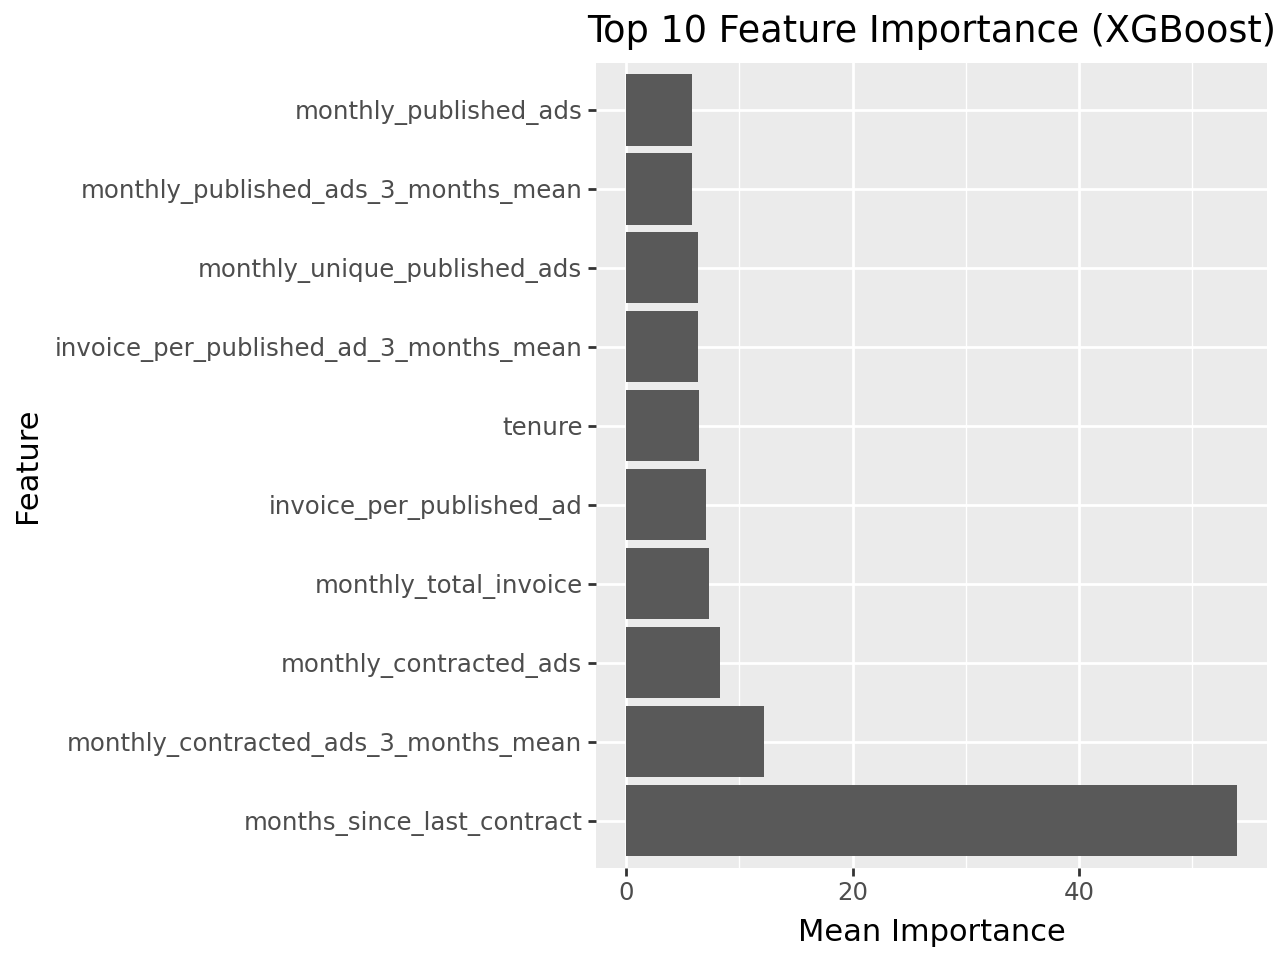

In [95]:
final_importance_df = final_importance_df.sort_values(["execution_date", "importance"], ascending=[False, False])

importance_summary = (
    final_importance_df
    .groupby("feature")["importance"]
    .mean()
    .reset_index()
)

top_features = (
    importance_summary
    .sort_values("importance", ascending=False)
    .head(10)
)

(
    ggplot(top_features) +
    geom_col(aes(x="feature", y="importance")) +
    coord_flip() +
    scale_x_discrete(limits=top_features["feature"].tolist()) +
    labs(title="Top 10 Feature Importance (XGBoost)", x="Feature", y="Mean Importance")
)
